# Asset-Liability Management

Funding ratio is an important indicator for telling us what is the fraction of 
liabilities that you are able to cover given the existing assets.

If the funding ratio is 100% or above that you are in a good shape because you are able to cover those liabilities.




# Present Value of Liabilities and Funding Ratio

In this lab session, we'll examine how to discount future liabilities to compute the present value of future liabilities, and measure the funding ratio.

The funding ratio is the ratio of the current value of assets to the present value of the liabilities.

In order to compute the present value, we need to discount the amount of the liability based on the relevant interest rate derived from the yield curve.

For simplicity, we'll assume that the yield curve is flat, and so the interest rate is the same for all horizons.

The present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is give by:

$$ PV(L) = \sum_{i=1}^{k} B(t_i) L_i$$

where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$

If we assume the yield curve is flat and the annual rate of interest is $r$ then $B(t)$ is given by

$$B(t) = \frac{1}{(1+r)^t}$$



In [2]:
import numpy as np
import pandas as pd
import risk_kit as rk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at a time t given interest rate r
    """
    return (1+r)**(-t)

In [4]:
discount(10, 0.03)

0.7440939148967249

In [5]:
0.7440939148967249*(1.03**10)

1.0

In [8]:
def pv(l ,r):
    """
    Computes the peresent value of a sequence of liabilities
    l is indexed by the time and the values are the amounts of each liability
    returns the peresent value of the sequence
    """

    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

In [7]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index = [3, 3.5, 4, 4.5])

In [10]:
pv(liabilities, 0.03)

6.233320315080045

In [11]:
liabilities

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [13]:
def funding_ratio(asset_value, liabilities, r):
    """
    Computes the funding ratio of some assets given liabilities and interest rate
    """
    return asset_value/pv(liabilities, r)

In [15]:
funding_ratio(5, liabilities, 0.03)
# Means that we have 80% of our liabilities covered.

0.8021407126958777

In [17]:
funding_ratio(5, liabilities, 0.02)
# Interest rate going down for funding ratios is not good as our 
# bonds will not grow as fast as if there was more interest rates

0.7720304366941648

In [18]:
funding_ratio(5, liabilities, 0.05)

0.8649082768407927

In [19]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

In [20]:
def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print(f'{fr*100:.2f}')

In [22]:
controls = widgets.interactive(show_funding_ratio, assets = widgets.IntSlider(min=1, max=10, step=1, value=5),
                               r = (0, 0.20, 0.01)
                               )

display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

# Liability Hedhing Portfolios

* Institutional investor's main concern is an **unexpected increase** in the present value of their liabilities

What can we do to immunize any increase?

* Goal Hedging Portfolios come in hadny for these increases.

GHPs are portfolios with payoffs mathcing the date and nominal amount of **liability/goal payments**

* A Standard Bond is **not safe** with respect to the goal, because it is too static.

* The Goal Hedging Portfolio is a Retirement Bond.

* When Cash-Flow Matching is not feasiable/practical, one may use **Factor Exposure Matching** instead.

# Simulating Interest Rate Changes and Liability Hedging
### Implementing the Cox Ingersoll Ross Model for interest rates

We saw in the previous lab that when you look at your financial condition in terms of funding ratio, rather than asset value, even cash can be a risky asset.

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model. It is very similar to what we have already done for generating random stock prices. Instead of a Geometric Brownian Motion, the mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ is the volatility parameter.

This can be read as describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the ${\sqrt  {r_{t}}}$ term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 

### Short Rate vs Annualized Rate

One final piece of math we'll need is that the interest rate being described here is the "instantaneous" or "short rate" ... we will often want to think about interest rates as annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:

$$ 1 + r_{annual} = e^{r_{inst}} $$

### Quick Explanation of Short Rate vs Annual Rate

The distinction between the instantaneous rate and the annualized rate is subtle if you have never had an opportunity to think about it, but is best understood in terms of an example:

Let's consider the growth of a dollar over a year, if the rate of interest is 100%.

To answer the question about what that will grow to at the end of the year, we'll need to answer a second question, which is how often will that interest be paid?

If it's paid just once at the end of the year, the answer is easy. The dollar grows to 2 dollars (one dollar in principle and another dollar in interest).

In [23]:
1 + 1*1

2

Now assume that I insist that you pay interest two times a year. i.e. I ask that the interest is compounded more frequently, at a shorter interval than just once a year, and instead it is compounded after every six months. That means, that at the end of 6 months, I pay out one half of the interest (50 cents). However, I now have \$1.50 for the remaining 6 months, and so the total value at the end of the year is the principal plus interest for the first period (50 cents) plus the interest for the second period which is one half of 1.50: 

In [24]:
1 + 1*.5 + 1.5*.5

2.25

Now let's try compounding it at an even shorter rate of once every 3 months, i.e. 4 times a year. We'd get:

In [25]:
1 + (1)*.25 + (1 + (1)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25)*.25)*.25

2.44140625

In general, if we compound every 1/N of a year (i.e. N times a year) we get:

$$\left(1+\frac{r}{N}\right)^N$$


In [26]:
(1+1/2)**2

2.25

In [27]:
(1+1/4)**4

2.44140625

In [28]:
(1+1/100)**100

2.7048138294215285

In [29]:
(1+1/10000)**10000

2.7181459268249255

## Implementation of the CIR Model

Let's start by defining a function to convert between instantaneous and annualized rates, and then write the code for generating the evolution of the interest rate:


In [31]:
import numpy as np
import pandas as pd
import risk_kit as rk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def inst_to_ann(r):
    """
    Converts short rate to an annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Covert annualized to a short rate
    """
    return np.log1p(r)

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

In [35]:
def cir(n_years = 10, n_scenarios = 1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """

    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year

    num_steps = int(n_years*steps_per_year)+1
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)

    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

<Axes: >

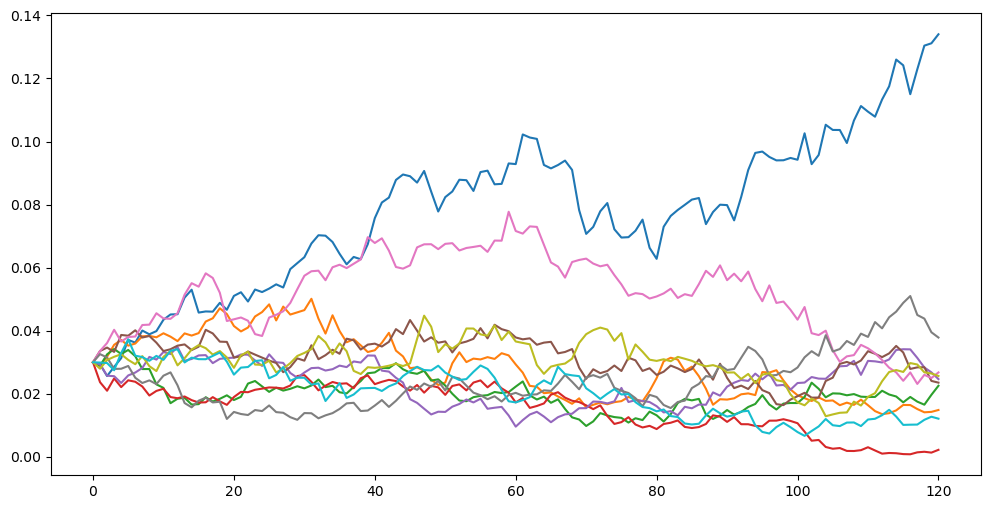

In [43]:
cir(n_scenarios=10).plot(figsize=(12, 6), legend=False)

In [39]:
import ipywidgets as widgets

In [52]:
def show_cir(r_0=0.03, a = 0.5, b = 0.03, sigma = 0.05, n_scenarios = 5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12, 6))

cir_controls = widgets.interactive(show_cir,
                                    n_scenarios = (1, 100),
                                    a = (0, 1, 0.1),
                                    b = (0, 0.15, 0.01),
                                    sigma = (0, 0.1, 0.01),
                                    r_0 = (0, 0.15, 0.01)
                                    )

In [50]:
from IPython.display import display

In [53]:
display(cir_controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [54]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices


In [55]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [58]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = rk.pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

<Axes: title={'center': 'Asset Values using Cash (10 scenarios)'}>

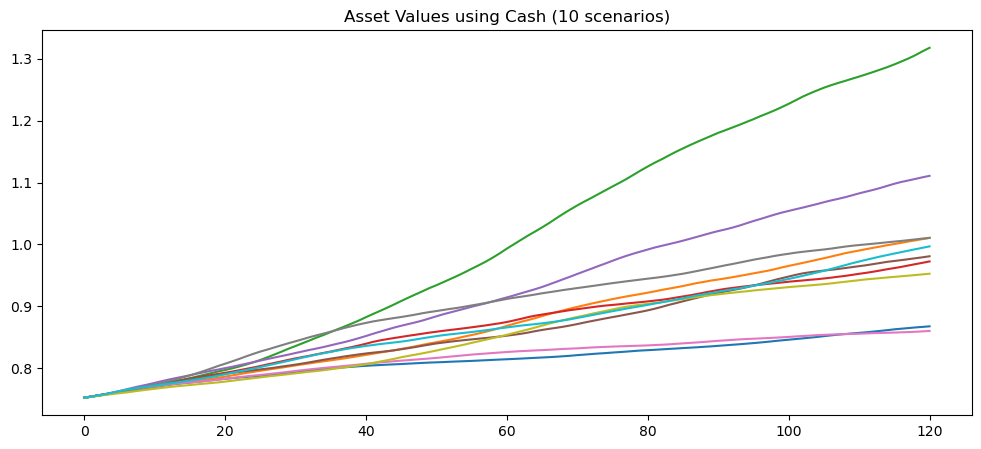

In [59]:
av_cash.plot(title='Asset Values using Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Asset Values using ZC Bonds (10 scenarios)'}>

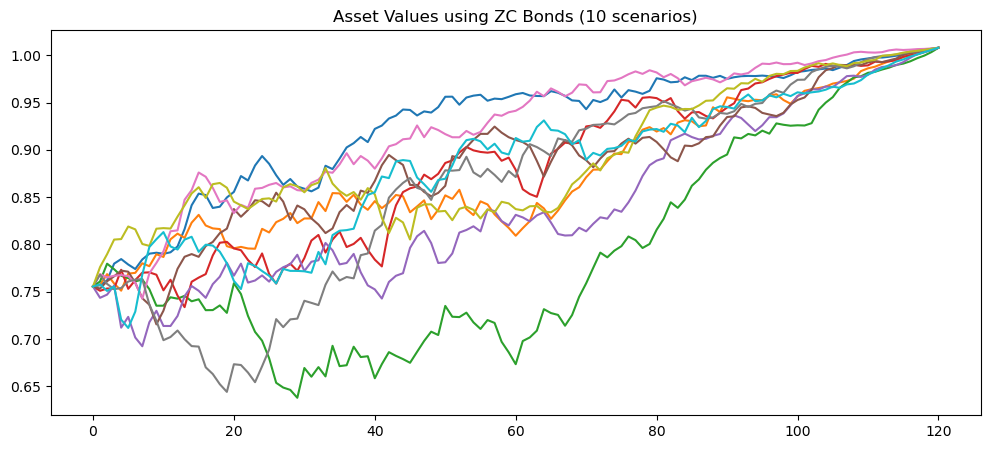

In [60]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Returns using Cash (10 scenarios)'}>

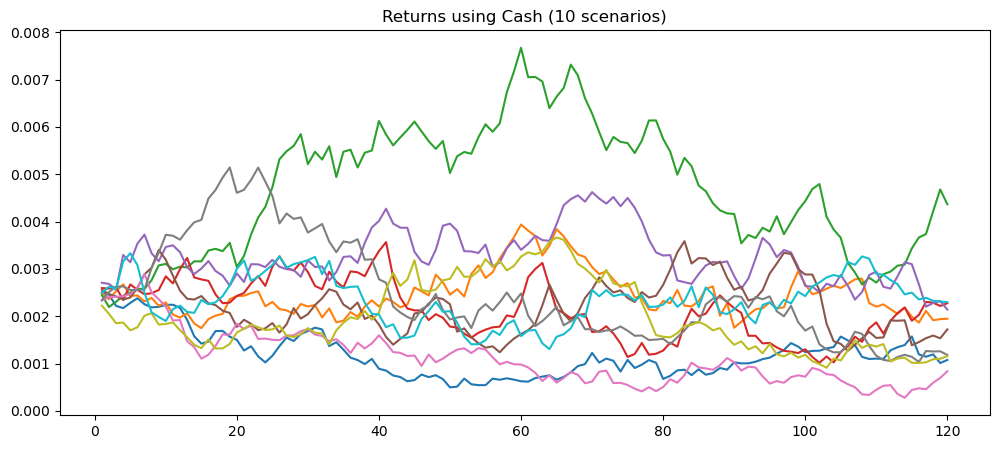

In [61]:
av_cash.pct_change().plot(title='Returns using Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Returns using Cash (10 scenarios)'}>

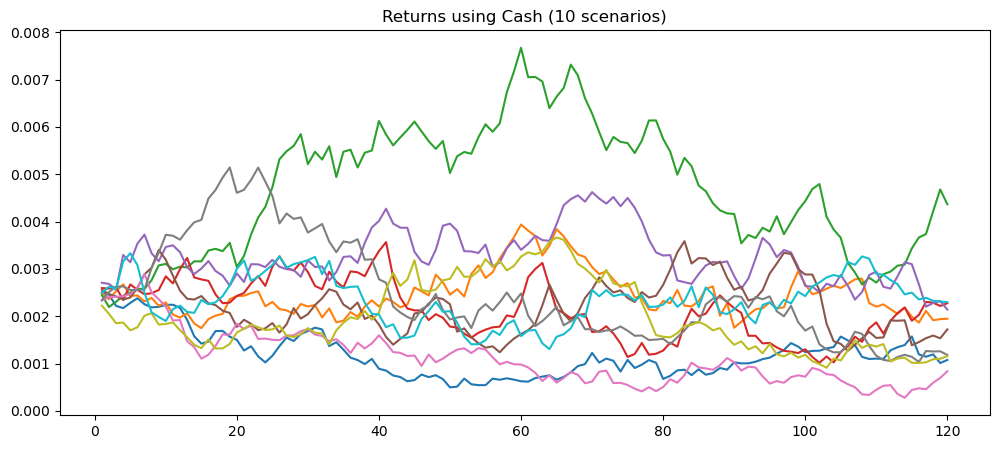

In [62]:
av_cash.pct_change().plot(title='Returns using Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Returns of Funding Ratio with Cash (10 scenarios)'}>

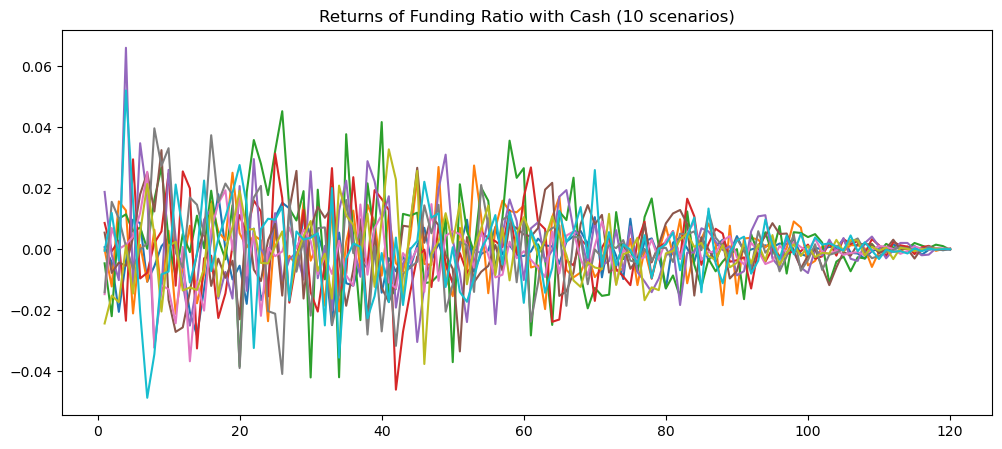

In [63]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Returns of Funding Ratio with ZC Bonds (10 scenarios)'}>

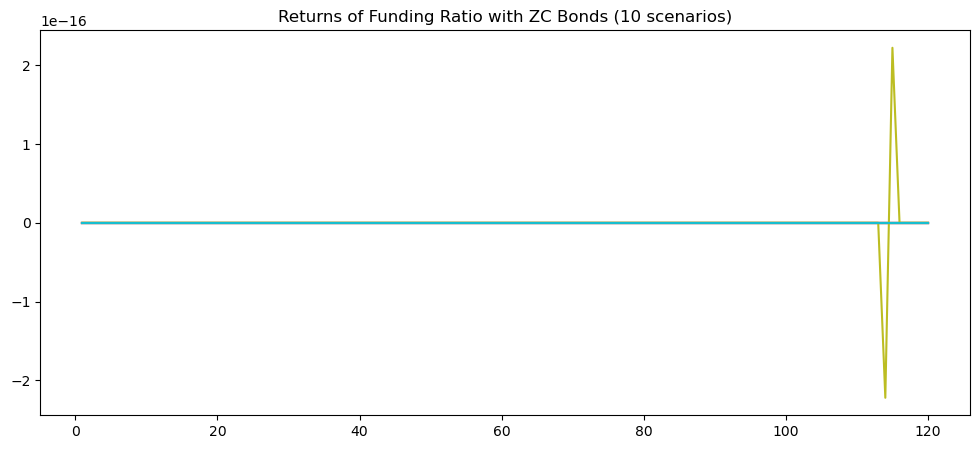

In [64]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Funding Ratio with Cash (10 scenarios)'}>

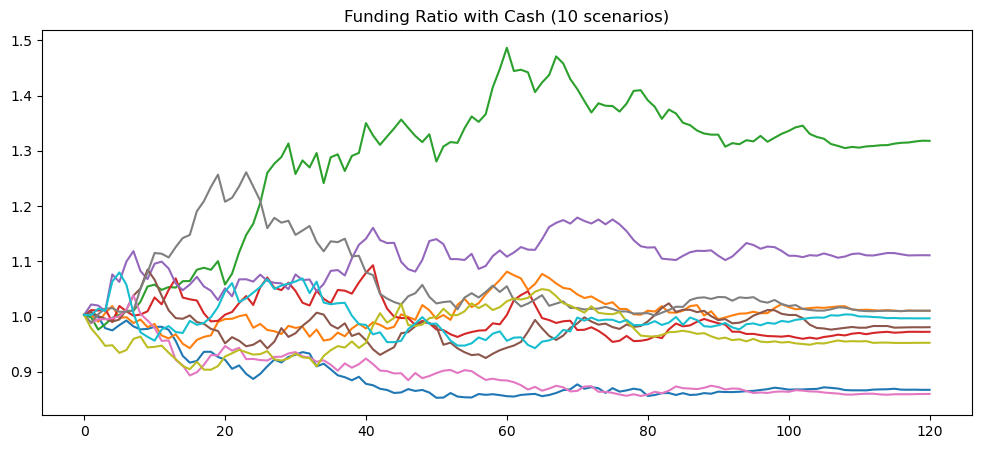

In [66]:
(av_cash/liabilities).plot(title='Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Funding Ratio with Cash (10 scenarios)'}>

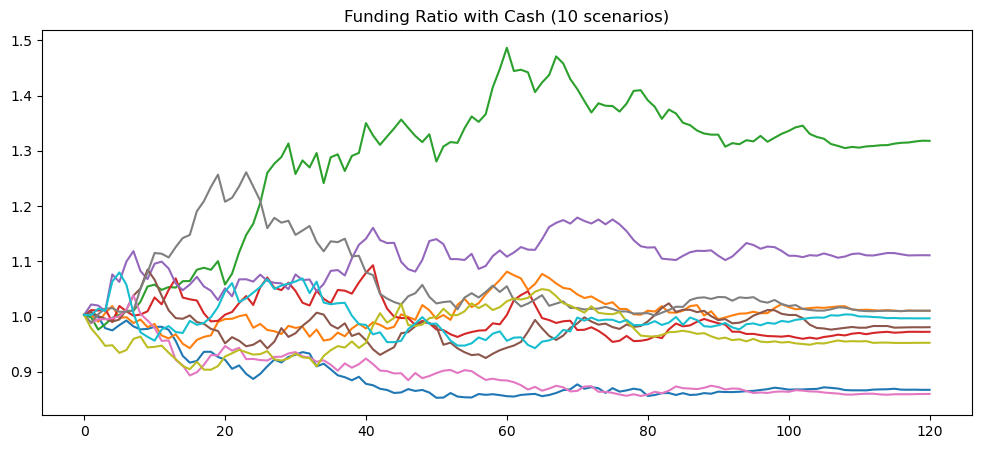

In [67]:
(av_cash/liabilities).plot(title='Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))